In [4]:
import torchvision as tv
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np

mnist_ds_path = '../datasets'
# you can change the batch_size, epochs, batch_limited to reach different accuracy
batch_size = 32
epochs = 15
batch_limited = 10000
alpha = 0.1
classes_num = 10
hidden_size = 128
w, h = 28, 28
layer0_w = np.random.normal(0, 0.01, (w*h, hidden_size))
layer1_w = np.random.normal(0, 0.01, (hidden_size, classes_num))

train_ds = tv.datasets.MNIST(root=mnist_ds_path, train=True, transform=transforms.ToTensor())
train_dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)  #60000

test_ds = tv.datasets.MNIST(root=mnist_ds_path, train=False, transform=transforms.ToTensor())
test_dataloader = DataLoader(test_ds, batch_size=batch_size, shuffle=True)    #10000

print('we have %d train samples, and %d test samples' % (len(train_dataloader), len(test_dataloader)))

we have 1875 train samples, and 313 test samples


In [50]:
def relu(x):
    return np.where(x>=0, x, 0)

def relu2driv(x):
    return np.where(x>0, 1, 0)

def dropout(x, dropout_prob):
    assert dropout_prob>=0 and dropout_prob<1   # when dropout_prob == 1, all are dropped out; dropout_prob == 0, nothing is dropped out
    
    ratio = 1.0/dropout_prob
    
    mask = np.random.uniform(0, 1.0, size=x.shape)
    mask = (mask >= dropout_prob).astype(np.int32)
    
    return x*mask*ratio, mask

In [51]:
def mse(gt, pred):
    num = gt.shape[0]
    y = np.zeros((num, classes_num))
    y[np.arange(num), gt] = 1
    return np.sum((y-pred)**2)

In [52]:
def acc(gt, pred):
    pred = pred.argmax(axis=1)
    return np.mean(gt == pred)

In [53]:
def forward(x, is_training, dropout_prob=0.5):
    x = x.reshape(x.shape[0], -1)
    mid_pred = relu(x.dot(layer0_w))
    
    if is_training and dropout_prob>0:
        mask_pred, mask = dropout(mid_pred, dropout_prob)
    else:
        mask_pred = mid_pred
        mask = None

    pred = mask_pred.dot(layer1_w)
    
    return pred, mid_pred, mask

def backward(gt, pred, mid_pred, mask, x):
    x = x.reshape(x.shape[0], -1)
    num = gt.shape[0]
    y = np.zeros((num, classes_num))
    y[np.arange(num), gt] = 1
    
    delta = 2*(pred-y)/num
    layer1_w_step = mid_pred.T.dot(delta)
    
    w_delta = delta.dot(layer1_w.T)*relu2driv(mid_pred)
    if mask is not None:
        w_delta = w_delta*mask
    layer0_w_step = x.T.dot(w_delta)
    
    return layer0_w_step, layer1_w_step

def step(alpha, layer0_w_step, layer1_w_step):
    global layer0_w, layer1_w
    layer0_w = layer0_w - alpha * layer0_w_step
    layer1_w = layer1_w - alpha * layer1_w_step
    
def test():
    loss = 0
    accuracy = 0
    for x,y in test_dataloader:
        x = x.cpu().numpy()
        y = y.cpu().numpy()
        
        pred, _, _ = forward(x, False)
        loss += mse(y, pred)
        accuracy += acc(y, pred)
    
    return loss/len(test_dataloader), accuracy/len(test_dataloader)

In [54]:
dropout_prob = 0.0
for epoch in range(epochs):
    loss = 0
    accuracy = 0
    for idx, (x,y) in enumerate(train_dataloader):
        x = x.cpu().numpy()
        y = y.cpu().numpy()
        
        pred, mid_pred, mask = forward(x, True, dropout_prob)
        loss += mse(y, pred)
        accuracy += acc(y, pred)
        
        layer0_w_step, layer1_w_step = backward(y, pred, mid_pred, mask, x)
        step(alpha, layer0_w_step, layer1_w_step)
        
        if idx >= batch_limited-1:
            break
    
    # do test
    test_loss, test_acc = test()
    print('in epoch %d, train loss: %.4f, train acc: %.4f, test loss: %.4f, test acc: %.4f' % \
          (epoch, loss/(idx+1), accuracy/(idx+1), test_loss, test_acc))

in epoch 0, train loss: 6.5584, train acc: 0.9151, test loss: 4.2852, test acc: 0.9583
in epoch 1, train loss: 3.9856, train acc: 0.9621, test loss: 3.6649, test acc: 0.9654
in epoch 2, train loss: 3.4526, train acc: 0.9697, test loss: 3.4377, test acc: 0.9689
in epoch 3, train loss: 3.1463, train acc: 0.9744, test loss: 3.2547, test acc: 0.9709
in epoch 4, train loss: 2.9640, train acc: 0.9767, test loss: 3.1057, test acc: 0.9726
in epoch 5, train loss: 2.8228, train acc: 0.9779, test loss: 2.9561, test acc: 0.9727
in epoch 6, train loss: 2.7194, train acc: 0.9790, test loss: 2.9647, test acc: 0.9719
in epoch 7, train loss: 2.6182, train acc: 0.9806, test loss: 2.9458, test acc: 0.9730
in epoch 8, train loss: 2.5489, train acc: 0.9812, test loss: 2.8696, test acc: 0.9738
in epoch 9, train loss: 2.4796, train acc: 0.9818, test loss: 2.8495, test acc: 0.9739
in epoch 10, train loss: 2.4245, train acc: 0.9825, test loss: 2.7945, test acc: 0.9753
in epoch 11, train loss: 2.3737, train acc

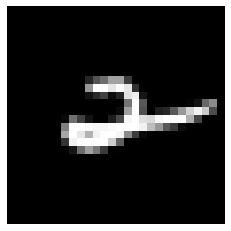

In [51]:
import numpy as np
from matplotlib import pyplot as plt

im = x[0,0,:,:]
fig = plt.figure()
plotwindow = fig.add_subplot(111)
plt.axis('off')
plt.imshow(im, cmap='gray')
plt.show()

# 求导公式 

## １、模型末端使用sigmoid作为输出，并使用cross entropy作为Loss Function的

### sigmoid 原始公式

$y=\frac{1}{1+e^{-x}}$

### sigmoid 求导

$y^{'}=-1\frac{1}{(1+e^{-x})^2}e^{-x}(-1) =\frac{e^{-x}}{(1+e^{-x})^2}=\frac{1}{1+e^{-x}}\frac{e^{-x}+1-1}{1+e^{-x}}=\frac{1}{1+e^{-x}}(1-\frac{1}{1+e^{-x}})=p_i(1-p_i)$

## cross entropy 原始公式

$ Loss=-y_ilogp_i-(1-y_i)log(1-p_i) $，   其中$y_i\in(0,1)$，这里$y_i$是真实值，$p_i$是模型预测值，也就是模型最后一层输出＋sigmoid的结果，这里注意一下和下面softmax的区别，因为sigmoid的输出只有１个，一般根据训练的batch大小为Ｎ×１，所以Loss函数如上所示，需要判断$ y_i $是０还是１，但是softmax输出有ｍ个（m为类别个数），一个批次的输出为Ｎ×ｍ，所以此时Loss函数如下:$ Loss={\sum_{j=0}^{n}{-y_ilogp_i}} $


## cross entropy 求导

$
Loss^{'}=
\begin{cases}
-1/p_i,&y_i=１ \\ 
1/(1-p_i),&y_i=0
\end{cases}
$

## sigmoid+cross entropy　合在一起为

$ \begin{eqnarray*}
\frac{dLoss}{dx} &=& \frac{dLoss}{dp_i}\frac{dpi}{dx}\\
&=& \begin{cases}
-1/p_i*p_i(1-p_i),&y_i=１ \\ 
1/(1-p_i)*p_i(1-p_i),&y_i=0
\end{cases} \\
&=& \begin{cases}
p_i-1,&y_i=１ \\ 
p_i,&y_i=0
\end{cases} \\
&=& p_i-y_i,&(y_i=0,y_i=1)
\end{eqnarray*}$

进一步的，上面求导公式中的ｘ为模型最后一层的输出，常见的情况是最后一层往往是一个Linear Classifier，比如pytorch常见的　　
nn.Linear(input_channels, classes_num)，这里classes_num为预测的类型数量，我们设　$ x = X_{input}W $, 那么如  
果要根据某一次前向推测的Loss计算$ W $的梯度，则我们只需要计算$ \frac{dx}{dW} $即可，那么根据链式求导法则，我们有：

$ \begin{eqnarray*}
\frac{dLoss}{dW} &=& \frac{dLoss}{dp_i}\frac{dpi}{dx}\frac{dx}{dＷ}\\
&=& X_{input}.T*(p_i-y_i)
\end{eqnarray*}$

## ２、模型末端使用softmax作为输出，并使用cross entropy作为Loss Function的

### softmax原始公式

$ p_i = \frac{e^{x_i}}{\sum_{j=0}^{n}{e^{x_j}}} $

### softmax求导

当$ i=j $时，$ \begin{eqnarray*}
p_i^{'} &=& \frac{e^{x_i}}{\sum_{j=0}^{n}{e^{x_j}}}+(-1)\frac{e^{x_i}}{(\sum_{j=0}^{n}{e^{x_j}})^2}e^{x_j}\\
&=& \frac{e^{x_i}}{\sum_{j=0}^{n}{e^{x_j}}}-(\frac{e^{x_i}}{\sum_{j=0}^{n}{e^{x_j}}})^2\\
&=& p_i-p_i^2\\
&=& p_i(1-p_i)
\end{eqnarray*}$

当$ i \neq j $时，$ \begin{eqnarray*}
p_i^{'} &=& (-1)\frac{e^{x_i}}{(\sum_{j=0}^{n}{e^{x_j}})^2}e^{x_j}\\
&=& (-1)\frac{e^{x_i}}{\sum_{j=0}^{n}{e^j}}\frac{e^{x_j}}{\sum_{j=0}^{n}{e^{x_j}}}\\
&=& -p_ip_j
\end{eqnarray*}$

可以得到：$ \frac{dp}{dx_i}=
\begin{cases}
p_i(1-p_i),&i=j \\ 
-p_ip_j,&i \neq j
\end{cases} $

同时交叉熵损失函数为$ Loss={\sum_{j=0}^{n}{-y_ilogp_i}} $

其导数为  $ dLoss/dp_i = -1/p_i $

那么，$ dLoss/dx_i = \frac{dLoss}{dp_i}\frac{dp_i}{dx_i} = \begin{cases}
p_i(1-p_i)*-1/p_i=p_i-1,&i=j \\ 
-p_ip_j*-1/p_i=p_j,&i \neq j
\end{cases}
$

这里我们也可以统一到$ dLoss/dx_i = p-y $

y为one-hot编码矩阵，例如　$ \left[ \begin{array} {cccc}
０&０&１&０\\
０&０&１&０\\
０&０&０&１\\
１&０&０&０
\end{array} \right] $

p为模型最后层输出后的softmax结果，其shape与ｙ相同，都是N*m，N为本批次样本数，ｍ为类别数量